In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Wed Jan 24 22:35:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
"""
Copyright (c) Facebook, Inc. and its affiliates.
This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import torch
from torch import nn
from torch.nn import functional as F


class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, LeakyReLU activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)


class TransposeConvBlock(nn.Module):
    """
    A Transpose Convolutional Block that consists of one convolution transpose layers followed by
    instance normalization and LeakyReLU activation.
    """

    def __init__(self, in_chans, out_chans):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

class ZerosNet(nn.Module):
    def __init__(self):
        super(ZerosNet, self).__init__()

    def forward(self, input):
        return input*0.0 + 0.0

class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.
    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch * 2, drop_prob)

        self.up_conv = nn.ModuleList()
        self.up_transpose_conv = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_transpose_conv += [TransposeConvBlock(ch * 2, ch)]
            self.up_conv += [ConvBlock(ch * 2, ch, drop_prob)]
            ch //= 2

        self.up_transpose_conv += [TransposeConvBlock(ch * 2, ch)]
        self.up_conv += [
            nn.Sequential(
                ConvBlock(ch * 2, ch, drop_prob),
                nn.Conv2d(ch, self.out_chans, kernel_size=1, stride=1),
            )]

        self.res = nn.Conv2d(in_chans+out_chans, out_chans, kernel_size=1, padding=0, bias=False)

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input

        # Apply down-sampling layers
        for i, layer in enumerate(self.down_sample_layers):
            output = layer(output)
            stack.append(output)
            output = F.avg_pool2d(output, kernel_size=2, stride=2, padding=0)

        output = self.conv(output)

        # Apply up-sampling layers
        for transpose_conv, conv in zip(self.up_transpose_conv, self.up_conv):
            downsample_layer = stack.pop()
            output = transpose_conv(output)

            # Reflect pad on the right/botton if needed to handle odd input dimensions.
            padding = [0, 0, 0, 0]
            if output.shape[-1] != downsample_layer.shape[-1]:
                padding[1] = 1  # Padding right
            if output.shape[-2] != downsample_layer.shape[-2]:
                padding[3] = 1  # Padding bottom
            if sum(padding) != 0:
                output = F.pad(output, padding, "reflect")

            output = torch.cat([output, downsample_layer], dim=1)
            output = conv(output)

        #concatentate input and output, perform 1x1 convolution (modification by Greg Ongie)
        output = self.res(torch.cat([input,output], dim=1))

        return output

In [5]:
model = UnetModel(in_chans=1, out_chans=1, num_pool_layers=4, drop_prob=0.0, chans=32)
model = model.to(device) #send to GPU

#model = torch.load('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/denoiser_net.pt')
#model.eval()

model = torch.load('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/denoiser_net_random_noise.pt')
model.eval()


UnetModel(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2, inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dro

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Load the measurement matrix and sinogram from file Data164.mat
# Load data from MATLAB file
mat_data = loadmat('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/Data328.mat')
A = mat_data['A']
m = mat_data['m']*10

# Proximal Gradient Descent
lambda_val = 0.1

# Define functions
def f(x):
    return 0.5 * np.linalg.norm(A @ x - m.ravel('F'))**2 + lambda_val * np.linalg.norm(x, 1)

def grad(x):
    return np.transpose(A) @ (A @ x - m.ravel('F'))

def sigma(s, mu):
    return np.maximum(np.abs(s) - mu, 0) * np.sign(s)

# Initialize parameters
x0 = np.zeros(A.shape[1])
n = A.shape[1]
tolerance = 1e-3
L = 625.6242  # normest(A.T @ A)

# Proximal gradient descent
def proximal_grad(A, x0, n, lambda_val, f, grad, sigma, tolerance, L):
    tau = 1 / L
    x_k = np.zeros(n)
    cost = [f(x_k)]  # Initialize cost array
    tol = tolerance  # Convergence tolerance

    # Main loop
    for k in range(100):
        z_k = x_k - (tau*grad(x_k))

        #  denoise(z_k)
        # First try
        #my_img = z_k.reshape((int(np.sqrt(n)),int( np.sqrt(n))))

        #pad_img = torch.zeros(512,512).to(device)
        #pad_img[92:92+328, 92:92+328] = torch.from_numpy(my_img).to(device)
        #pad_img = pad_img + 0.01*torch.randn_like(pad_img)
        #with torch.no_grad():
        #  pad_img  = model(pad_img[None,None,:])[0][0].detach() #unet estimate
        #x_k = pad_img[92:92+328,92:92+328]
        #x_k = x_k.cpu().numpy().flatten()

        # Second try -> random level of noise
        my_img = z_k.reshape((int(np.sqrt(n)),int( np.sqrt(n))))
        my_img = torch.from_numpy(my_img).to(device).float()
        with torch.no_grad():
          x_k_new  = model(my_img[None,None,:])[0][0].detach() #unet estimate

        # 'Normal pgd'
        #mu = lambda_val * tau
        #x_k_new = sigma(z_k, mu)

        x_k = x_k_new.cpu().numpy().flatten()
        cost.append(f(x_k))

    return x_k, cost

# Run proximal gradient descent
x, cost = proximal_grad(A, x0, n, lambda_val, f, grad, sigma, tolerance, L)

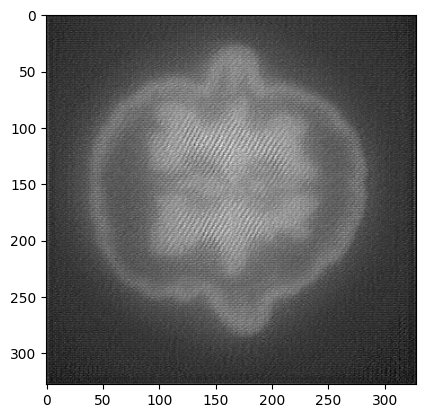

<Figure size 640x480 with 0 Axes>

In [18]:
# Plot results
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x.reshape((int(np.sqrt(n)),int( np.sqrt(n)))), cmap='gray')
plt.show()

plt.figure()
plt.show()

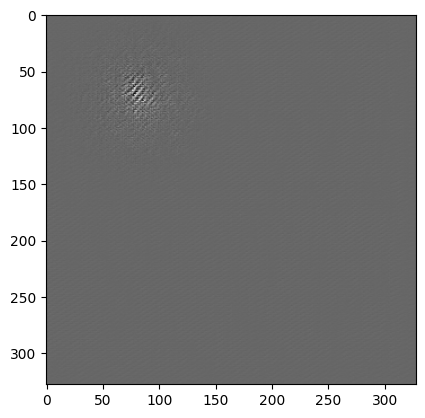

In [11]:
# Try denoise a single image with the denoiser
#image = np.load(x)#, mmap_mode = "r")


#truth_img = torch.from_numpy(image[0]).to(device) #get test image
#noisy_img = truth_img #+ std*torch.randn_like(truth_img) #add random Gaussian noise
#x.shape

# pad image here, then denoise, then extract the center

noisy_img = torch.randn(512,512).to(device)
for i in range(1,100):
  with torch.no_grad():
    noisy_img  = model(noisy_img[None,None,:])[0][0].detach() #unet estimate

# plot
plt.imshow(noisy_img.cpu(), cmap="gray")

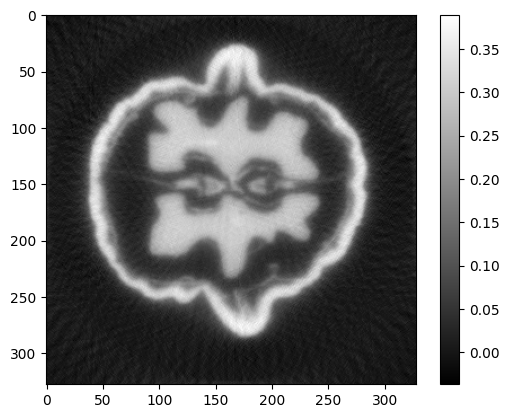

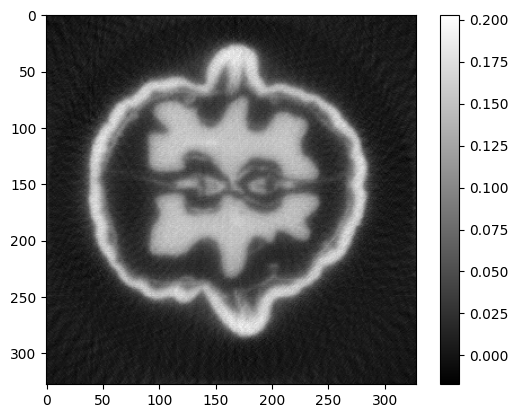

In [14]:
from torchvision.transforms import v2
my_img = x.reshape((int(np.sqrt(n)),int( np.sqrt(n))))

#pad_img = torch.zeros(512,512).to(device)
#pad_img[92:92+328, 92:92+328] = torch.from_numpy(my_img).to(device)
#pad_img = pad_img + 0.01*torch.randn_like(pad_img)

pad_img =  torch.from_numpy(my_img).to(device).float()
plt.figure()
plt.imshow(pad_img.cpu(), cmap='gray')
plt.colorbar()
plt.show()

#for i in range(1,100):
with torch.no_grad():
  pad_img  = model(pad_img[None,None,:])[0][0].detach() #unet estimate

plt.figure()
plt.imshow(pad_img.cpu(), cmap='gray')
plt.colorbar()
plt.show()

# Try training with different level of noises
#-----> aparently made it worse on the toy example, removed less noise (got level noises randomly * 0.1 ),
# in the walnut case it worked way better than the previous one, but not good yet
# TRY EVEN LESS NOISE?

# deblur instead of denoise  A'A

# TRY to make the training close to the walnuts
# torch downsample, desize, shrink by 2
# reshape everything to 328, then train again
#-----> Reshaping it kind of broke, did not work even with the test at the end of script
# TRY ON WALNUT, JUST IN CASE

# gray scales are different - multiply phantos by different scaliing factors (rand between 0 1 (maybe other range to match test set) )

#denoised_img  = noisy_img - net(noisy_img[None,None,:])[0][0] #unet estimate do it in training